In [1]:
path = ""

In [2]:
# ## UNCOMMENT THIS CELL IF USING GOOGLE COLAB ###

# from google.colab import drive

# drive.mount('/content/drive', force_remount=True)

# # Enter the path in your Drive..
# FOLDERNAME = "ViT"

# assert FOLDERNAME is not None, "[!] Enter the foldername."

# # Now that we've mounted your Drive, this ensures that
# # the Python interpreter of the Colab VM can load
# # python files from within it.
# import sys
# sys.path.append(f'/content/drive/My Drive/{FOLDERNAME}')

# path = f'/content/drive/My Drive/{FOLDERNAME}'

In [3]:
!pip install datasets

%load_ext autoreload
%autoreload 2

import os
import torch
import torchvision
import matplotlib.pyplot as plt
from Scheduler import Scheduler
from utils import *
from model import Transformer
from datasets import load_dataset
from dataset import ImageNet
from torch.utils.data import DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(device)


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


cuda:0


In [4]:
tiny_imagenet_dataset = load_dataset("zh-plus/tiny-imagenet", cache_dir="dataset")

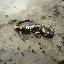

In [5]:
tiny_imagenet_dataset["train"][500]["image"]

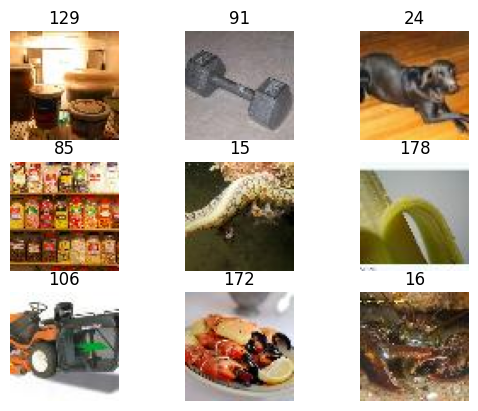

In [6]:
show_samples(tiny_imagenet_dataset["train"])

In [7]:
(H, W, C) = get_image_shape(tiny_imagenet_dataset["train"][500]["image"])

print((H, W, C))

(64, 64, 3)


In [8]:
P = 16
N = (H*W)//(P**2)

print((P,N))

(16, 16)


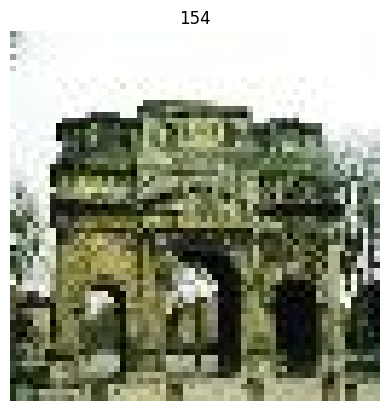

In [9]:
idx = np.random.randint(low = 0, high = len(tiny_imagenet_dataset["train"]))
test_image = tiny_imagenet_dataset["train"][idx]
show_image(test_image)

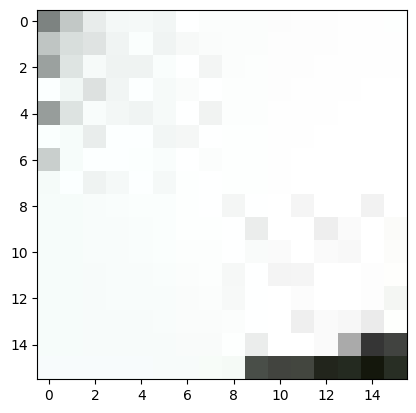

In [10]:
patches_test = images_to_patches([test_image["image"]], res_patch = 16)
plt.imshow(patches_test[0,0])
plt.show()

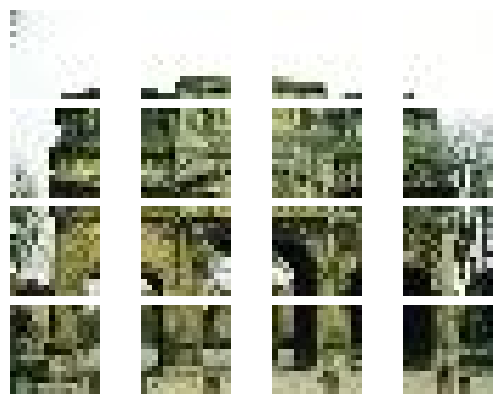

In [11]:
show_patches(patches_test[0])

torch.Size([1, 16, 768])
torch.Size([1, 16, 16, 16, 3])


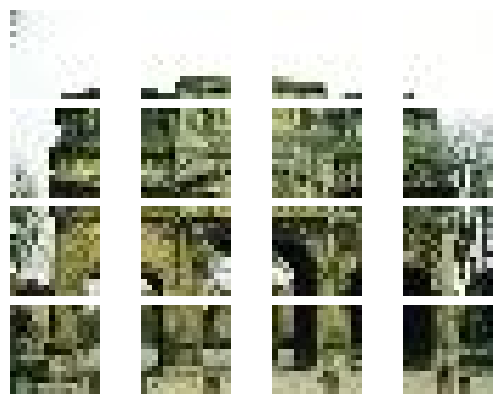

In [12]:
flat_patches = flatten_patches(patches_test)
print(flat_patches.shape)

patches = flat_to_patches(flat_patches, N = 16, P = 16, C = 3)
print(patches.shape)

show_patches(patches[0])

In [13]:
val_ratio = 0.3
splitted = tiny_imagenet_dataset["train"].train_test_split(val_ratio)
print(splitted)
imagenet_train = ImageNet(data = splitted["train"],
                         to_paches_fn = images_to_patches,
                         res_patch = 16)

imagenet_val = ImageNet(data = splitted["test"],
                         to_paches_fn = images_to_patches,
                         res_patch = 16)

imagenet_test = ImageNet(data = tiny_imagenet_dataset["valid"],
                         to_paches_fn = images_to_patches,
                         res_patch = 16)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 70000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 30000
    })
})


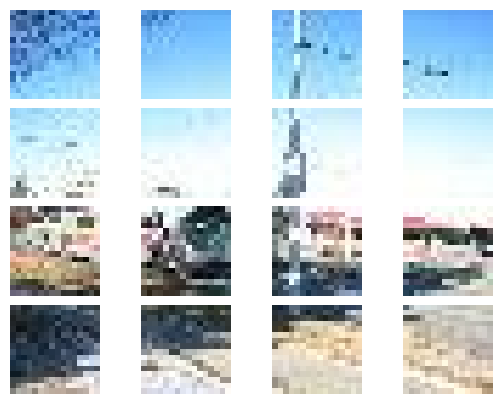

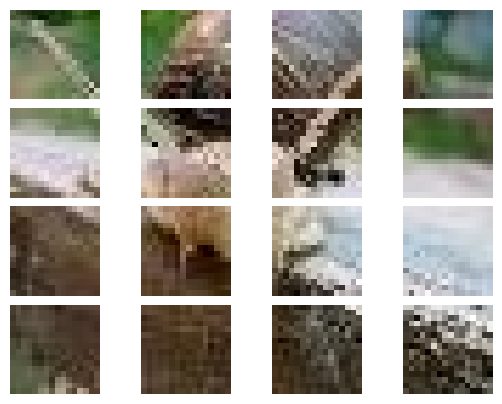

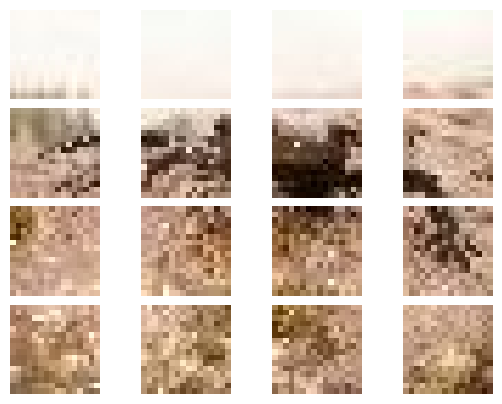

In [14]:
show_patches(flat_to_patches(imagenet_train[50]["image_patches_flatten"], N = 16, P = 16, C = 3)[0])
show_patches(flat_to_patches(imagenet_val[50]["image_patches_flatten"], N = 16, P = 16, C = 3)[0])
show_patches(flat_to_patches(imagenet_test[50]["image_patches_flatten"], N = 16, P = 16, C = 3)[0])

inputs batch shape: torch.Size([512, 1, 16, 768])
labels batch shape: torch.Size([512])
label : 78


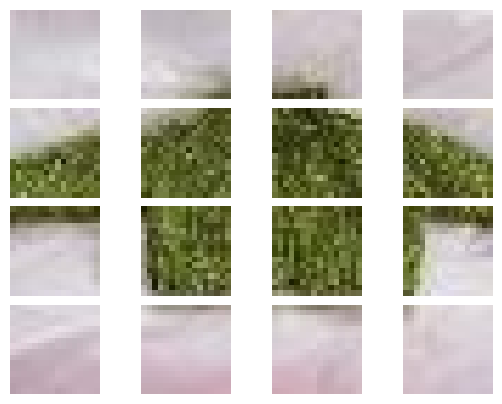

In [15]:
batch_size = 512
trainLoaders = {}

train_dataloader = DataLoader(imagenet_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(imagenet_val, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(imagenet_test, batch_size=batch_size, shuffle=True)

trainLoaders["train"] = train_dataloader
trainLoaders["val"] = val_dataloader


## Generating an example ##
for i,batch in enumerate(iter(train_dataloader)):

    inputs,targets = batch["image_patches_flatten"],batch["label"]
    idx = np.random.randint(0,len(inputs))
    if i < 1:
        print(f"inputs batch shape: {inputs.size()}")
        print(f"labels batch shape: {targets.size()}")
        sample = (inputs[idx],targets[idx])
        
        print(f"label : {sample[1]}")
        show_patches(flat_to_patches(sample[0], N = 16, P = 16, C = 3)[0])
        
        break

In [16]:
model = Transformer(image_features_dim = (P**2)*C, no_classes = 1000, src_max_len = N, noHeads = 12, d_model = 768, d_ff = 3072, 
                 dropout = 0.1, noEncoder = 2, device =device).to(device)

In [17]:
print(f"Numeber of the model's trainable paramaters : {count_parameters(model)}")

Numeber of the model's trainable paramaters : 15543016


In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [19]:
scheduler = Scheduler(optimizer =  optimizer,
                 dim_embed= 768,
                 warmup_steps=400)

In [34]:
## An example of the untrained model prediction ##
out = model(imagenet_train[:10]["image_patches_flatten"])
print(out.shape)

print(f"True label : {imagenet_train[:10]['label']}")
print(f"Prediction : {torch.argmax(torch.softmax(out,dim = -1),dim = 1)}")

## The prediction loss ##
loss = classificationLoss(output=out, target=torch.tensor([imagenet_train[:10]['label']]).to(device))
print(loss)

acc = score(out, torch.tensor([imagenet_train[:10]['label']]).to(device), kind = "accuracy")
print(acc)

torch.Size([10, 1000])
True label : [60, 158, 123, 177, 28, 194, 146, 87, 135, 107]
Prediction : tensor([ 60, 158, 123, 177,  28, 194, 146,  87, 135, 107], device='cuda:0')
tensor(0.0193, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1., device='cuda:0')


In [21]:
if not (os.path.exists("trained")):
        os.mkdir("trained")

filename = "vit-weights-base"

In [23]:
train_cum_losses, val_cum_losses = [], []

In [30]:
trainedModel, train_losses, val_losses = train_model(model, trainLoaders, classificationLoss, 
                           optimizer, scheduler = scheduler, num_epochs=20, device = device, isSave=True,
                           filename = filename, verbose = False)

train_cum_losses += train_losses
val_cum_losses += val_losses

torch.save(trainedModel.state_dict(), f"trained/{filename}")
# !cp -r './trained/transformer-weights-small' /content/drive/MyDrive/

Epoch 0/19
----------


Predicting ...:   0%|          | 0/137 [00:00<?, ?it/s]

train prev epoch Loss: 0
train current epoch Loss: 398.1277884392843, lr = 0.00048142487083002717


Predicting ...:   0%|          | 0/59 [00:00<?, ?it/s]

val prev epoch Loss: 0
val current epoch Loss: 3989.6254793587377, lr = 0.00048142487083002717
Epoch 1/19
----------


Predicting ...:   0%|          | 0/137 [00:00<?, ?it/s]

train prev epoch Loss: 398.1277884392843
train current epoch Loss: 356.26137662455983, lr = 0.00047566010346504896


Predicting ...:   0%|          | 0/59 [00:00<?, ?it/s]

val prev epoch Loss: 3989.6254793587377
val current epoch Loss: 4082.860977560787, lr = 0.00047566010346504896
Epoch 2/19
----------


Predicting ...:   0%|          | 0/137 [00:00<?, ?it/s]

train prev epoch Loss: 356.26137662455983
train current epoch Loss: 333.3198274069459, lr = 0.0004700975858401294


Predicting ...:   0%|          | 0/59 [00:00<?, ?it/s]

val prev epoch Loss: 4082.860977560787
val current epoch Loss: 4095.095095359673, lr = 0.0004700975858401294
Epoch 3/19
----------


Predicting ...:   0%|          | 0/137 [00:00<?, ?it/s]

train prev epoch Loss: 333.3198274069459
train current epoch Loss: 304.1250724444424, lr = 0.0004647257618487278


Predicting ...:   0%|          | 0/59 [00:00<?, ?it/s]

val prev epoch Loss: 4095.095095359673
val current epoch Loss: 4215.5611993822, lr = 0.0004647257618487278
Epoch 4/19
----------


Predicting ...:   0%|          | 0/137 [00:00<?, ?it/s]

train prev epoch Loss: 304.1250724444424
train current epoch Loss: 275.3492223781391, lr = 0.00045953397915455754


Predicting ...:   0%|          | 0/59 [00:00<?, ?it/s]

val prev epoch Loss: 4215.5611993822
val current epoch Loss: 4276.342288001109, lr = 0.00045953397915455754
Epoch 5/19
----------


Predicting ...:   0%|          | 0/137 [00:00<?, ?it/s]

train prev epoch Loss: 275.3492223781391
train current epoch Loss: 248.10751973451488, lr = 0.00045451240030008877


Predicting ...:   0%|          | 0/59 [00:00<?, ?it/s]

val prev epoch Loss: 4276.342288001109
val current epoch Loss: 4356.127295283948, lr = 0.00045451240030008877
Epoch 6/19
----------


Predicting ...:   0%|          | 0/137 [00:00<?, ?it/s]

train prev epoch Loss: 248.10751973451488
train current epoch Loss: 236.80580015600162, lr = 0.00044965192427262043


Predicting ...:   0%|          | 0/59 [00:00<?, ?it/s]

val prev epoch Loss: 4356.127295283948
val current epoch Loss: 4399.355775218899, lr = 0.00044965192427262043
Epoch 7/19
----------


Predicting ...:   0%|          | 0/137 [00:00<?, ?it/s]

train prev epoch Loss: 236.80580015600162
train current epoch Loss: 225.267789523967, lr = 0.0004449441171043854


Predicting ...:   0%|          | 0/59 [00:00<?, ?it/s]

val prev epoch Loss: 4399.355775218899
val current epoch Loss: 4463.184125480006, lr = 0.0004449441171043854
Epoch 8/19
----------


Predicting ...:   0%|          | 0/137 [00:00<?, ?it/s]

train prev epoch Loss: 225.267789523967
train current epoch Loss: 197.48000874484543, lr = 0.0004403811503021623


Predicting ...:   0%|          | 0/59 [00:00<?, ?it/s]

val prev epoch Loss: 4463.184125480006
val current epoch Loss: 4565.787866107488, lr = 0.0004403811503021623
Epoch 9/19
----------


Predicting ...:   0%|          | 0/137 [00:00<?, ?it/s]

train prev epoch Loss: 197.48000874484543
train current epoch Loss: 197.97108438589277, lr = 0.000435955746083454


Predicting ...:   0%|          | 0/59 [00:00<?, ?it/s]

val prev epoch Loss: 4565.787866107488
val current epoch Loss: 4573.55885728739, lr = 0.000435955746083454
Epoch 10/19
----------


Predicting ...:   0%|          | 0/137 [00:00<?, ?it/s]

train prev epoch Loss: 197.97108438589277
train current epoch Loss: 177.55574072538502, lr = 0.00043166112854746864


Predicting ...:   0%|          | 0/59 [00:00<?, ?it/s]

val prev epoch Loss: 4573.55885728739
val current epoch Loss: 4631.89576617742, lr = 0.00043166112854746864
Epoch 11/19
----------


Predicting ...:   0%|          | 0/137 [00:00<?, ?it/s]

train prev epoch Loss: 177.55574072538502
train current epoch Loss: 157.2387321639235, lr = 0.0004274909800354808


Predicting ...:   0%|          | 0/59 [00:00<?, ?it/s]

val prev epoch Loss: 4631.89576617742
val current epoch Loss: 4703.662241531631, lr = 0.0004274909800354808
Epoch 12/19
----------


Predicting ...:   0%|          | 0/137 [00:00<?, ?it/s]

train prev epoch Loss: 157.2387321639235
train current epoch Loss: 148.7038494687881, lr = 0.00042343940204113585


Predicting ...:   0%|          | 0/59 [00:00<?, ?it/s]

val prev epoch Loss: 4703.662241531631
val current epoch Loss: 4735.764930078539, lr = 0.00042343940204113585
Epoch 13/19
----------


Predicting ...:   0%|          | 0/137 [00:00<?, ?it/s]

train prev epoch Loss: 148.7038494687881
train current epoch Loss: 143.54586382677957, lr = 0.00041950088012048176


Predicting ...:   0%|          | 0/59 [00:00<?, ?it/s]

val prev epoch Loss: 4735.764930078539
val current epoch Loss: 4842.339038913533, lr = 0.00041950088012048176
Epoch 14/19
----------


Predicting ...:   0%|          | 0/137 [00:00<?, ?it/s]

train prev epoch Loss: 143.54586382677957
train current epoch Loss: 135.33395500252718, lr = 0.0004156702523268865


Predicting ...:   0%|          | 0/59 [00:00<?, ?it/s]

val prev epoch Loss: 4842.339038913533
val current epoch Loss: 4862.524188801393, lr = 0.0004156702523268865
Epoch 15/19
----------


Predicting ...:   0%|          | 0/137 [00:00<?, ?it/s]

train prev epoch Loss: 135.33395500252718
train current epoch Loss: 122.232141000511, lr = 0.00041194268075987793


Predicting ...:   0%|          | 0/59 [00:00<?, ?it/s]

val prev epoch Loss: 4862.524188801393
val current epoch Loss: 4916.9918106854975, lr = 0.00041194268075987793
Epoch 16/19
----------


Predicting ...:   0%|          | 0/137 [00:00<?, ?it/s]

train prev epoch Loss: 122.232141000511
train current epoch Loss: 122.43650787590194, lr = 0.0004083136258712532


Predicting ...:   0%|          | 0/59 [00:00<?, ?it/s]

val prev epoch Loss: 4916.9918106854975
val current epoch Loss: 4965.056263551874, lr = 0.0004083136258712532
Epoch 17/19
----------


Predicting ...:   0%|          | 0/137 [00:00<?, ?it/s]

train prev epoch Loss: 122.43650787590194
train current epoch Loss: 120.9111690451629, lr = 0.0004047788232181254


Predicting ...:   0%|          | 0/59 [00:00<?, ?it/s]

val prev epoch Loss: 4965.056263551874
val current epoch Loss: 4959.034901764433, lr = 0.0004047788232181254
Epoch 18/19
----------


Predicting ...:   0%|          | 0/137 [00:00<?, ?it/s]

train prev epoch Loss: 120.9111690451629
train current epoch Loss: 116.66702458110169, lr = 0.00040133426239218956


Predicting ...:   0%|          | 0/59 [00:00<?, ?it/s]

val prev epoch Loss: 4959.034901764433
val current epoch Loss: 5055.131046101198, lr = 0.00040133426239218956
Epoch 19/19
----------


Predicting ...:   0%|          | 0/137 [00:00<?, ?it/s]

train prev epoch Loss: 116.66702458110169
train current epoch Loss: 113.03141293560502, lr = 0.0003979761678884716


Predicting ...:   0%|          | 0/59 [00:00<?, ?it/s]

val prev epoch Loss: 5055.131046101198
val current epoch Loss: 5072.730116763358, lr = 0.0003979761678884716

Training complete in 58m 19s
Best val loss: 3989.625479


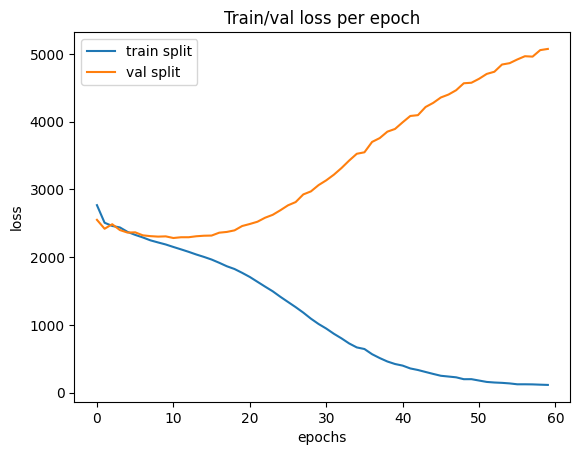

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(np.arange(len(train_cum_losses)), train_cum_losses, label = 'train split')
ax.plot(np.arange(len(val_cum_losses)), val_cum_losses, label = "val split")

ax.set_xlabel("epochs")
ax.set_ylabel("loss")
ax.set_title("Train/val loss per epoch")
ax.legend()

plt.show()

In [32]:
results = evaluate_model(model, train_dataloader, device = device)

Predicting ...:   0%|          | 0/137 [00:00<?, ?it/s]

 Result : 0.9958030581474304

Evaluating complete in 1m 34s


In [26]:
model.load_state_dict(torch.load(os.path.join(path,os.path.join("trained",filename))))

<All keys matched successfully>